In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import glob
from scipy.interpolate import interp1d
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import matplotlib.pyplot as plt

In [2]:
sp_names = glob.glob("SN2012fr*.dat")
len(sp_names)

20

In [3]:
time = []
wave = []
flux = []

In [4]:
for i in range(0, len(sp_names)):
    
    file = open(sp_names[i])
    lines = file.readlines()
    file.close()
    
    timetemp = lines[0]
    timetemp = timetemp[:-1]
    timetemp = float(timetemp[1:])

    y = []
    z = []
    
    for line in lines:
        if line.startswith('#'): continue
        co=line.rstrip().replace('INDEF','Nan').split()

        y.append(float(co[0]))
        z.append(float(co[1]))
            
    time.append(timetemp)
    wave.append(y)
    flux.append(z)

In [5]:
kernel = 1* RBF(length_scale=5.0, length_scale_bounds=(1, 10)) + WhiteKernel(noise_level=1e-1, noise_level_bounds=(1e-5, 0.5))

waves_pic = np.array([4000, 5000, 6000, 7000, 8000])
X_ = np.linspace(-10, 50, 60 + 1)
final_gradey = np.linspace(2000, 9200, 721)
y_mean_list = []
y_cov_list = []


In [6]:
data_x = []
data_z = []

for i in range(0, len(waves_pic)):
    
    xx = []
    zz = []
    
    for j in range(0, len(wave)):
        
        if min(wave[j]) < waves_pic[i] < max(wave[j]):
            
            interpolation = interp1d(wave[j], np.array(flux[j]))

            
            xx.append([time[j]])
            zz.append(interpolation(waves_pic[i]))
            
    data_x.append(xx)
    data_z.append(np.array(zz)/max(zz))
            
    gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0).fit(xx, np.array(zz)/max(zz))

    y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)
    
    y_mean_list.append(y_mean)

    y_cov_list.append(y_cov)

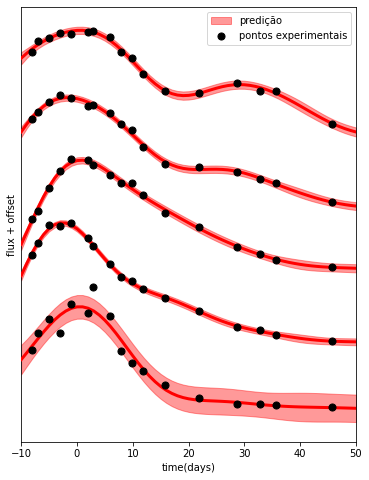

In [13]:
offset = 0
plt.figure(figsize=(6, 8))
for i in range(0, len(waves_pic)):
    
    if i == 0:
        
        plt.fill_between(X_, y_mean_list[i] - np.sqrt(np.diag(y_cov_list[i])) + offset, y_mean_list[i] + np.sqrt(np.diag(y_cov_list[i])) + offset, alpha=0.4, color='r', label = 'predição')
        plt.scatter(data_x[i], data_z[i] + offset, c='k', s=50, zorder=10, edgecolors=(0, 0, 0), label = 'pontos experimentais')
        plt.plot(X_, y_mean_list[i] + offset, 'r', lw=3, zorder=9)

        offset += 0.5
        
    else:
        
        plt.fill_between(X_, y_mean_list[i] - np.sqrt(np.diag(y_cov_list[i])) + offset, y_mean_list[i] + np.sqrt(np.diag(y_cov_list[i])) + offset, alpha=0.4, color='r')
        plt.scatter(data_x[i], data_z[i] + offset, c='k', s=50, zorder=10, edgecolors=(0, 0, 0))
        plt.plot(X_, y_mean_list[i] + offset, 'r', lw=3, zorder=9)

        offset += 0.5
    
plt.xlim(-10,50)

plt.yticks([])
plt.xlabel("time(days)")
plt.ylabel("flux + offset")
plt.legend(loc="upper right")
plt.savefig("lc2012fr.jpg", dpi = 200)   # save the figure to file
plt.show()